# 007 多层感知机的简洁实现

In [7]:
# Import package
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import transforms
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据并处理数据

### 读取 Fashion-MNIST 数据集

In [8]:
def load_data_fashion_mnist(batch_size, resize=None, workers=4):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data",
        train=True,
        transform=trans,
        download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data",
        train=False,
        transform=trans, download=True
    )
    return (
        data.DataLoader(
            mnist_train,
            batch_size,
            shuffle=True,
            num_workers=workers
        ),
        data.DataLoader(
            mnist_test,
            batch_size,
            shuffle=False,
            num_workers=workers
        )
    )


batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(
    batch_size=batch_size,
    workers=4
)


## 定义模型

### 多层感知机

实现一个具有但隐藏层的多层感知机, 包含256个隐藏单元, 并使用激活函数

In [9]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weights)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

## Loss 与 优化函数

In [10]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)


## 开始训练

### 训练前准备

In [11]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """在动画中绘制数据。"""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_epoch(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(
        xlabel='epoch',
        xlim=[1, num_epochs],
        ylim=[0.3, 0.9],
        legend=['train loss', 'train acc', 'test acc']
    )
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


### 开始训练

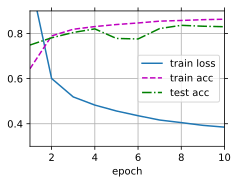

In [12]:
train(net, train_iter, test_iter, loss, num_epochs, trainer)


## 对图像进行分类预测

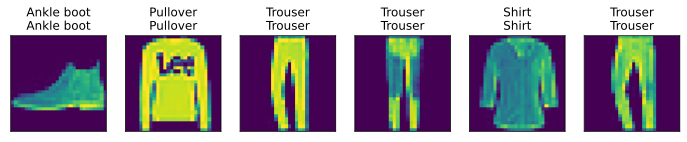

In [13]:
def show_image(imgs, rows, cols, titles=None, scale=2):
    figsize = (cols*scale, rows*scale)
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


def get_labels(labels):
    text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                   'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    return [text_labels[int(i)] for i in labels]

def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_labels(y)
    preds = get_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_image(
        X[0:n].reshape((n, 28, 28)), 1, n,
        titles=titles[0:n]
    )


predict(net, test_iter)